In [513]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Finding transition weeks
### What is a transition week?
Transition weeks are the starting and ending week of a phenophase, for example, the first and last weeks of a trees 'budding flowers' period. We can think of transition weeks as the first week that the percent of observations observing an attribute (say budding flowers) exceeds some small threshold, such as 10%.

### Our approach
We assign each week $w$ a score, $s(w)$. Then, for each year $Y$, we normalize the scores to get the probability $w$ is a transition week, $p(w)$. 

$$
    p(w) = \frac{s(w)}{\sum_{w \in Y} s(w)}
$$

Let $y(k)$ be the percentage of observations observing an attribute for a species each week. To identify weeks at the beginning of a phenophase, we use the following score function:

$$
    s(w) = w_1 \left|\max_{w - L \leq k \leq w} y(k) - \min_{w - L \leq k \leq w} y(k)\right|^{-1} + w_2 \prod_{k=w+1}^{w+M} e^{y(k) - y(k-1)}
$$

The first term we call 'stagnation'. It is large when there is little change in the M weeks before $w$. The second term we call 'spike'. It is large if there are large increases in percentage after week $w$. Weeks at the end of plateaus in the percentage plots which experience spikes directly afterwards should have high scores

### Next Steps
We have tried tuning the parameters of this formula on mango for the attribute Fruits_ripe, and it has proved difficult to tune. We are unsure of whether we should modify this formula or seek a different approach.

## Helper functions for calculating percents and number of observations

In [514]:
def get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr):
    species_df = state_df[state_df['Species_id'] == species_id]
    species_df = species_df[species_df['Year'] == year]
    species_df = species_df[species_df[attr] >= 0]
    pcts = []
    for week in range(48):
        species_df_week = species_df[species_df['Week'] == week]
        N = len(species_df_week)
        if N == 0:
            pcts.append(0)
        else:
            species_df_week_observed = species_df_week[species_df_week[attr] > 0]
            pcts.append(len(species_df_week_observed) / N)
    return pcts

In [515]:
def num_observations(state_df, year, week, species_id, attr):
    species_df = state_df[state_df['Species_id'] == species_id]
    species_df = species_df[species_df['Year'] == year]
    species_df = species_df[species_df[attr] >= 0]
    species_df_week = species_df[species_df['Week'] == week]
    return len(species_df_week)

## Score Function (Old)

In [516]:
def get_scores(state_df, species_id, attr, L=5, M=3, w_1=1, w_2=1, w_3=1, size_term=False):
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores = []
    stagns = []
    spikes = []
    sizes = []
    for week in range(L, len(pcts)-M, 1): # todo - calculate score for weeks before week L
        #print(pcts[week-L:week+1])
        stagn = (1 / (0.1 + max(pcts[week-L:week+1]) - min(pcts[week-L:week+1])))**2
        # if stagn < 5:
        #     stagn = 0
        
        differences_arr = np.array([pcts[k + 1] - pcts[k] for k in range(week, week+M, 1)])
        spike = np.prod(np.exp(differences_arr))
        size = 1 / (0.01 + pcts[week])
        # calculate spike based on net change
        # diff = pcts[week + M] - pcts[week]
        # spike = np.exp(5*diff)
        
        spikes.append(spike)
        stagns.append(stagn)
        sizes.append(size)
    #print(scores)
    spikes = 100 * (np.array(spikes) - np.min(spikes)) / np.max(spikes)
    sizes = 100 * (np.array(sizes) - np.min(sizes)) / np.max(sizes)
    if size_term:
        scores = (w_1 * np.array(stagns) + w_2 * np.array(spikes) + w_3 * np.array(sizes)) / 3
        return list(scores), list(spikes), list(stagns), list(sizes)
    scores = (w_1 * np.array(stagns) + w_2 * np.array(spikes)) / 2
    return list(scores), list(spikes), list(stagns)

## Helper functions for plotting

In [529]:
def plot_score_and_pcts(species_id, attr, L=5, M=3, w_1=1, w_2=1, w_3=1, size_term=False):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    if size_term:
        scores, spikes, stagns, sizes = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=size_term)
    else:
        scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=size_term)
    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M)])
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))
    
    fig, ax = plt.subplots()
    ax.plot(range(len(pcts)), pcts, label=f'percent of observations observing {attr}')
    for ex in expected_values:
        ax.axvline(x=ex, color='r', linestyle='--', linewidth=2, label='mean transition times')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left')
    ax.set(xlabel='week', ylabel='percent of observations')
    twin = ax.twinx()
    twin.bar(range(len(pcts)), scores, label='unnormalized week score', alpha=0.25)
    twin.set(ylabel='score')
    plt.title(f"Mango (all species), {attr} probs / pcts, L={L}, M={M}, w_1={w_1}, w_2={w_2}, w_3={w_3}")
    twin.legend(loc='upper right')
    plt.show()
    
    for idx, year in enumerate(list(range(2018, 2024))):
        if year != 2020 and year != 2021:
            continue
        fig, ax = plt.subplots()
        ax.plot(range(48), pcts[48*idx:48*idx+48], label=f'percent of observations of attribute {attr}')
        ax.axvline(x=expected_values[idx] % 48, color='r', linestyle='--', linewidth=2, label='mean transition time')
        ax.legend(loc = 'lower left')
        ax.set(xlabel='week', ylabel='percent of observations')
        twin = ax.twinx()
        scores_for_year = scores[48*idx:48*idx+48].copy()
        probs_for_year = scores_for_year / np.sum(scores_for_year)
        #print(probs_for_year)
        twin.bar(range(48), probs_for_year, label='probability of week being a transition week', alpha=0.25)
        twin.legend(loc='upper right')
        twin.set(ylabel='probability')
        plt.title(f"Average transition time for Mango (all species) {attr} in Kerala, {year}, L={L}, M={M}, w_1={w_1}, w_2={w_2}, w_3={w_3}")

In [530]:
def plot_score_for_one_year(year, species_id, attr, L=5, M=3, w_1=1, w_2=1):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    for y in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, y, species_id, attr)
    scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)

    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M)])
    
    #print(scores)
    print(f"len scores {len(scores)}, len pcts {len(pcts)}")
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))

    idx = year - 2018
    fig, ax = plt.subplots()
    ax.plot(range(48), pcts[48*idx:48*idx+48], label=f'percent of observations of attribute {attr}')
    ax.axvline(x=expected_values[idx] % 48, color='r', linestyle='--', linewidth=2, label='mean transition time')
    ax.legend(loc = 'lower left')
    ax.set(xlabel='week', ylabel='percent of observations')
    twin = ax.twinx()
    scores_for_year = scores[48*idx:48*idx+48].copy()
    probs_for_year = scores_for_year / np.sum(scores_for_year)
    twin.bar(range(48), probs_for_year, label='probability of week being a transition week', alpha=0.25)
    twin.legend(loc='upper right')
    twin.set(ylabel='score')
    plt.title(f"Average transition time for Mango (all species) {attr} in Kerala, {year}, L={L}, M={M}, w_1={w_1}, w_2={w_2}")

In [531]:
def plot_stagnations(species_id, attr, L=5, M=3, w_1=1, w_2=1, w_3=1, size_term=False):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    if size_term:
        scores, spikes, stagns, sizes = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=size_term)
    else:
        scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=size_term)
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)

    stagns = np.array([0 for i in range(L)] + stagns + [0 for i in range(M)])
    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M)])
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))
    
    fig, ax = plt.subplots()
    ax.plot(range(len(pcts)), pcts, label=f'percent of observations observing {attr}')
    for ex in expected_values:
        ax.axvline(x=ex, color='r', linestyle='--', linewidth=2, label='mean transition times')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left')
    ax.set(xlabel='week', ylabel='percent of observations')
    twin = ax.twinx()
    twin.bar(range(len(pcts)), stagns, label='unnormalized week stagnation', alpha=0.25)
    twin.set(ylabel='score')
    plt.title(f"Mango (all species), {attr} probs / pcts, L={L}, M={M}, w_1={w_1}, w_2={w_2}")
    twin.legend(loc='upper right')
    plt.show()

    # for idx, year in enumerate(list(range(2018, 2024))):
    #     fig, ax = plt.subplots()
    #     ax.plot(range(48), pcts[48*idx:48*idx+48], label=f'percent of observations of attribute {attr}')
    #     ax.axvline(x=expected_values[idx] % 48, color='r', linestyle='--', linewidth=2, label='mean transition time')
    #     ax.legend(loc = 'lower left')
    #     ax.set(xlabel='week', ylabel='percent of observations')
    #     twin = ax.twinx()
    #     stagns_for_year = stagns[48*idx:48*idx+48].copy()
    #     #print(probs_for_year)
    #     twin.bar(range(48), stagns_for_year, label='stagnation', alpha=0.25)
    #     twin.legend(loc='upper right')
    #     twin.set(ylabel='score')
    #     plt.title(f"Average transition time for Mango (all species) {attr} in Kerala, {year}, L={L}, M={M}, w_1={w_1}, w_2={w_2}")

def plot_spikes(species_id, attr, L=5, M=3, w_1=1, w_2=1, w_3=1, size_term=False):
    state_df = pd.read_csv('all data/citizen/kerala.csv')
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    if size_term:
        scores, spikes, stagns, sizes = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=size_term)
    else:
        scores, spikes, stagns = get_scores(state_df, species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=size_term)

    spikes = np.array([0 for i in range(L)] + spikes + [0 for i in range(M)])
    scores = np.array([0 for i in range(L)] + scores + [0 for i in range(M)])
    
    expected_values = []

    for i in range(0,len(scores), 48):
        scores_for_year = scores[i:i+48].copy()
        scores_for_year /= np.sum(scores_for_year)
        expected_values.append(np.dot(scores_for_year, range(i, i+48)))
    
    fig, ax = plt.subplots()
    ax.plot(range(len(pcts)), pcts, label=f'percent of observations observing {attr}')
    for ex in expected_values:
        ax.axvline(x=ex, color='r', linestyle='--', linewidth=2, label='mean transition times')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='lower left')
    ax.set(xlabel='week', ylabel='percent of observations')
    twin = ax.twinx()
    twin.bar(range(len(pcts)), spikes, label='unnormalized week spike', alpha=0.25)
    twin.set(ylabel='score')
    plt.title(f"Mango (all species), {attr} probs / pcts, L={L}, M={M}, w_1={w_1}, w_2={w_2}")
    twin.legend(loc='upper right')
    plt.show()

    for idx, year in enumerate(list(range(2018, 2024))):
        if year != 2020:
            continue
        fig, ax = plt.subplots()
        ax.plot(range(48), pcts[48*idx:48*idx+48], label=f'percent of observations of attribute {attr}')
        ax.axvline(x=expected_values[idx] % 48, color='r', linestyle='--', linewidth=2, label='mean transition time')
        ax.legend(loc = 'lower left')
        ax.set(xlabel='week', ylabel='percent of observations')
        twin = ax.twinx()
        spikes_for_year = spikes[48*idx:48*idx+48].copy()
        #print(probs_for_year)
        twin.bar(range(48), spikes_for_year, label='unnormalized week spike', alpha=0.25)
        twin.legend(loc='upper right')
        twin.set(ylabel='score')
        plt.title(f"Average transition time for Mango (all species) {attr} in Kerala, {year}, L={L}, M={M}, w_1={w_1}, w_2={w_2}")

## Initial Experiments
- Experiment with different values of the stagnation weight
- Plots of score function with weeks from all years aggregated into the same plot
- Plots of probability function for the year 2020

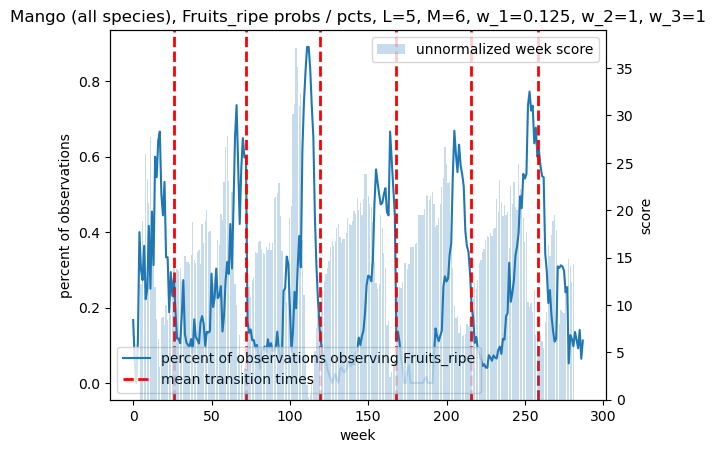

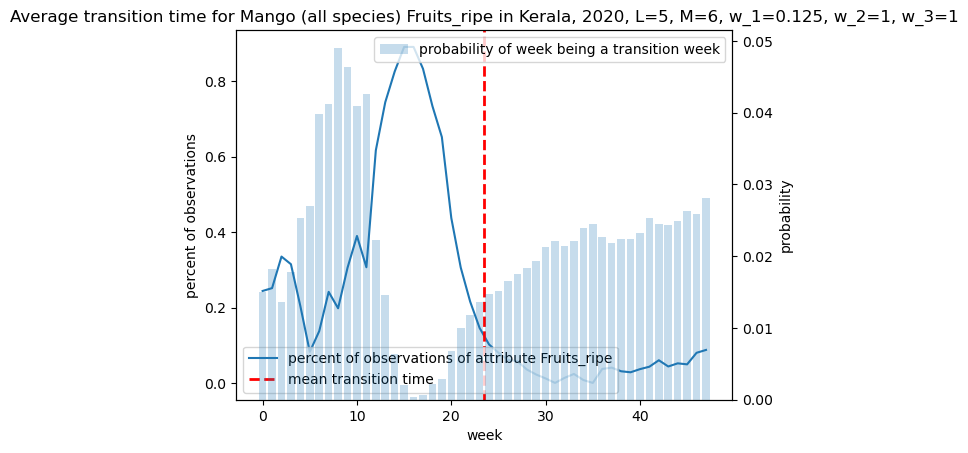

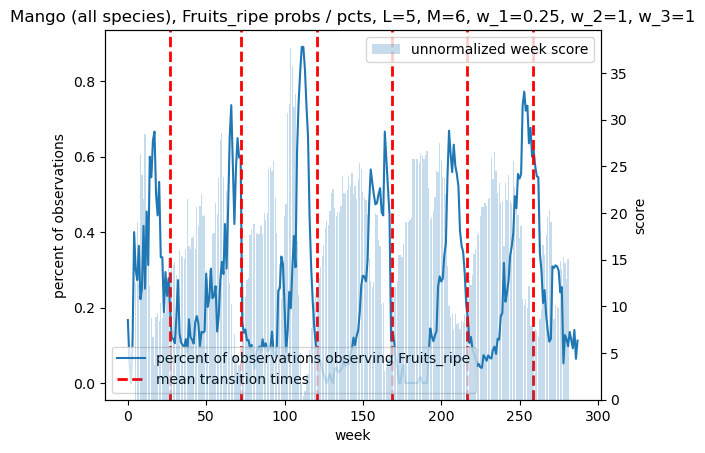

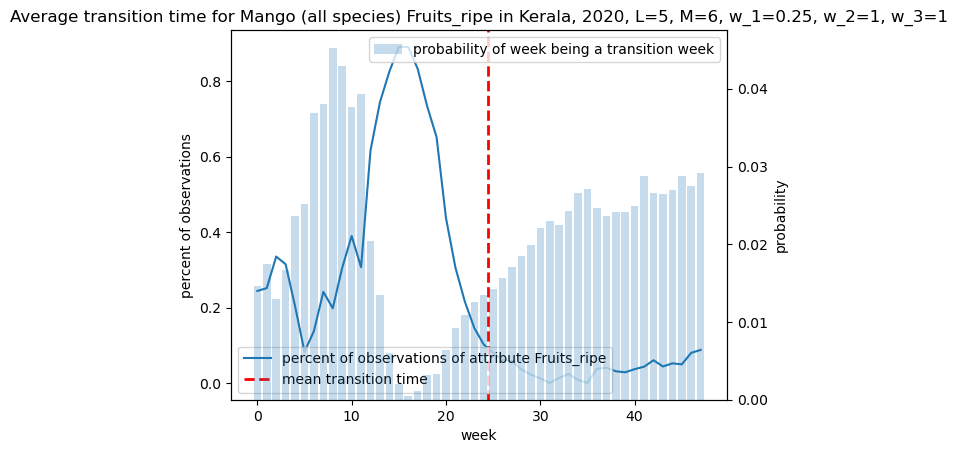

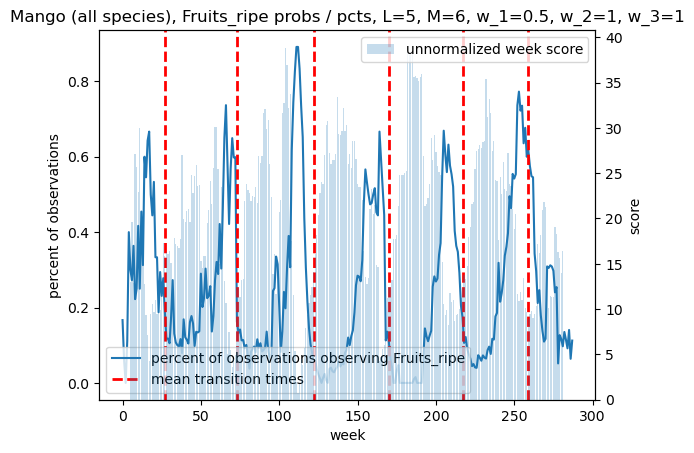

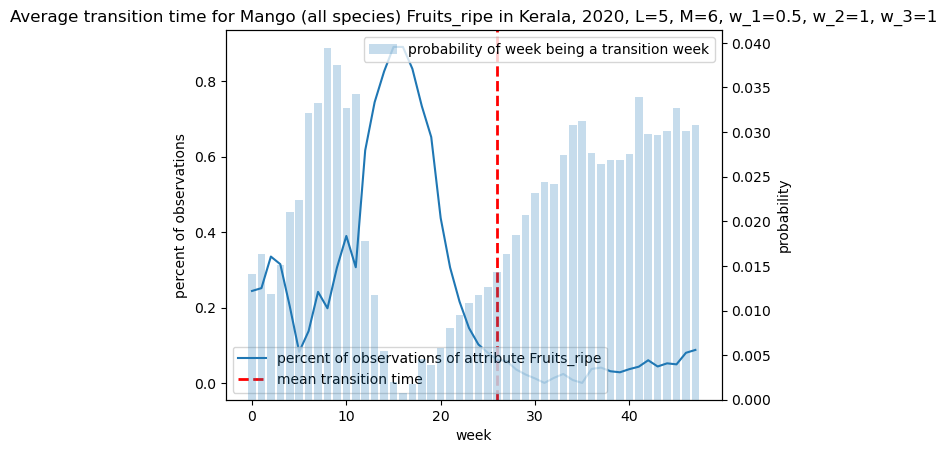

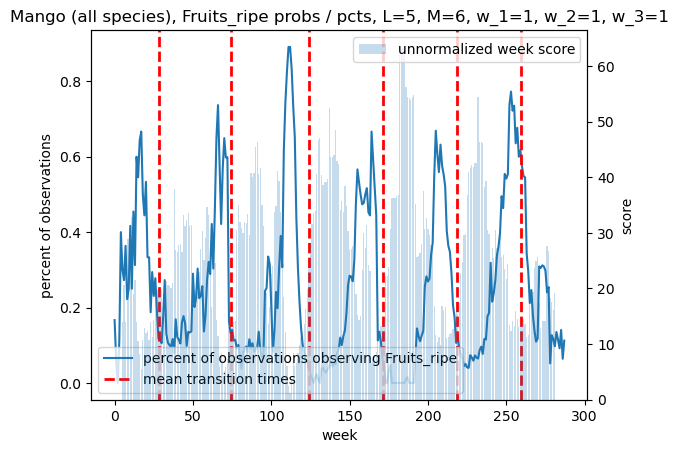

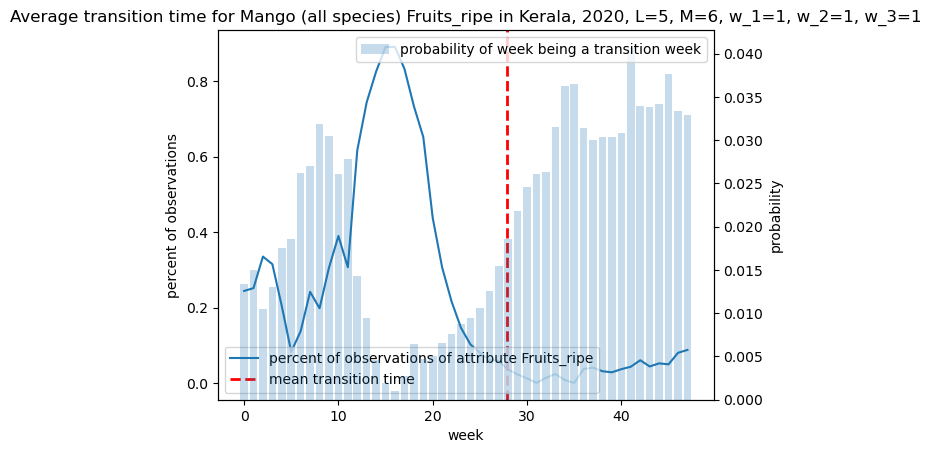

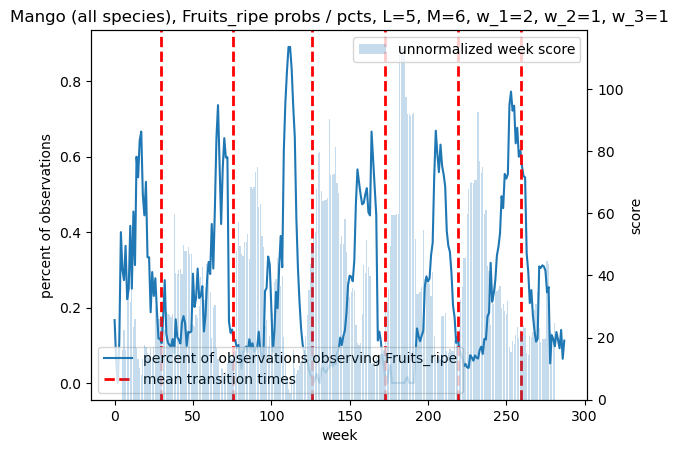

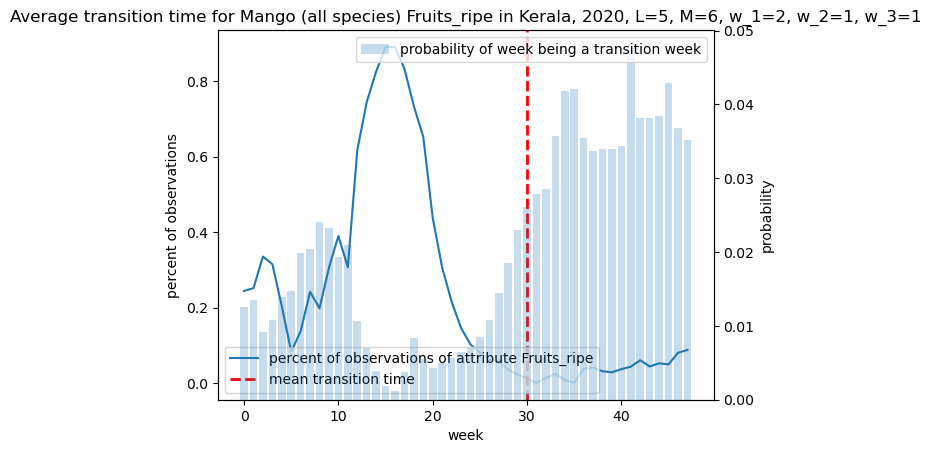

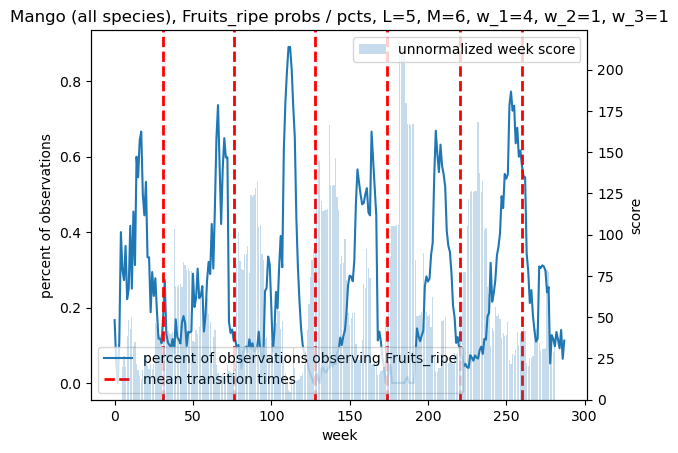

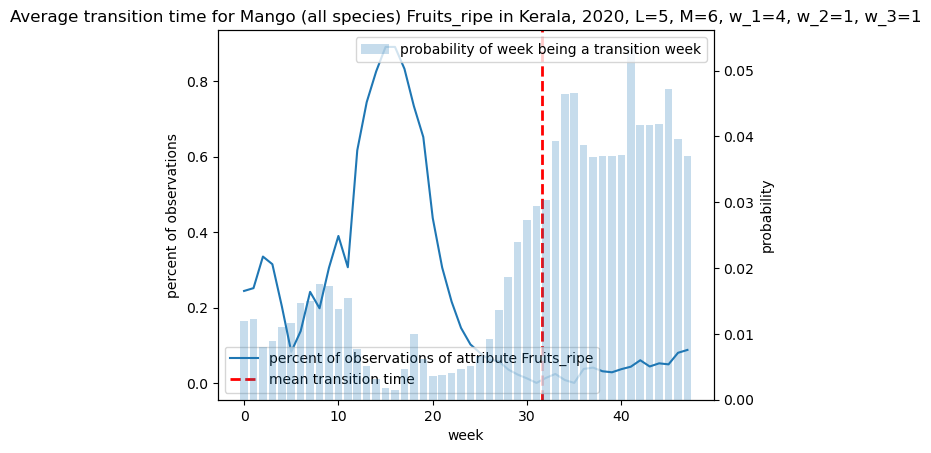

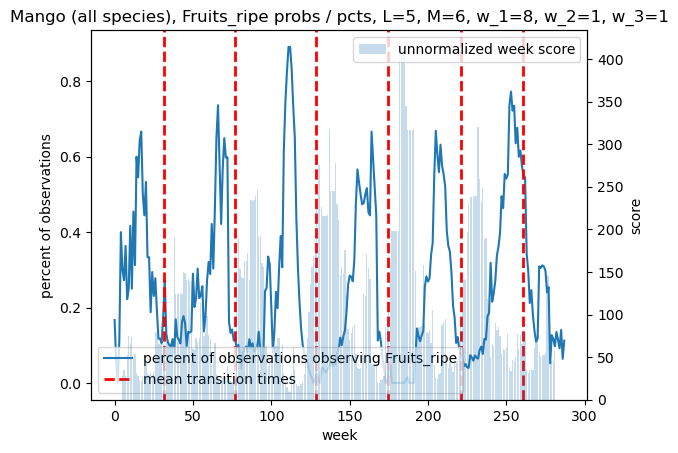

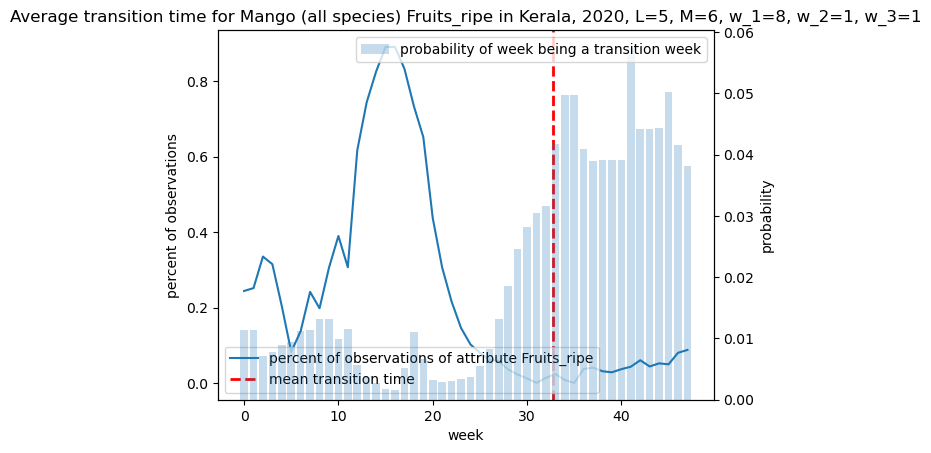

In [520]:
year = 2022
species_id = 1090
for w_1 in [0.125, 0.25, 0.5, 1, 2, 4, 8]:
    for w_2 in [1]:
        for M in [6]:
            for L in [5]:
                for attr in ['Fruits_ripe']:
                    # plot_stagnations(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)
                    # plot_spikes(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)
                    plot_score_and_pcts(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, size_term=False)
                #plot_score_for_one_year(year, 1161, attr, L=5, M=M, w_1=w_1, w_2=w_2)

## Experimenting with size term
Add a third term to the expression for $s(w)$ which assigns higher scores to weeks with lower percentages.

$$
    s(w) = w_1 \left|\max_{w - L \leq k \leq w} y(k) - \min_{w - L \leq k \leq w} y(k)\right|^{-1} + w_2 \prod_{k=w+1}^{w+M} e^{y(k) - y(k-1)} + w_3\frac{1}{y(w)}
$$

We experiment with different values of the size weight, $w_3$, and fix $w_1=w_2=1$.

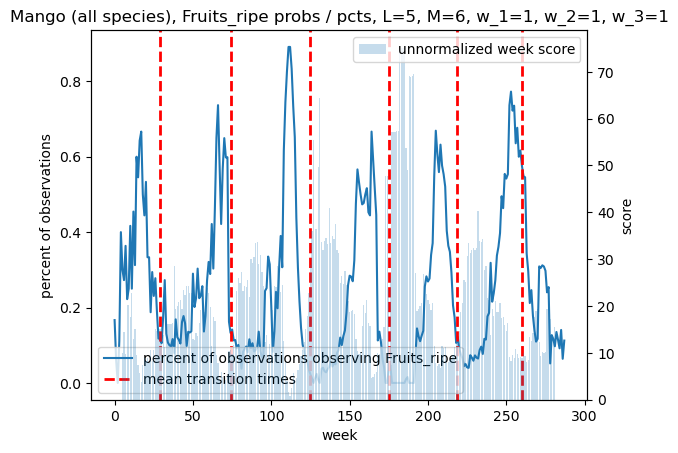

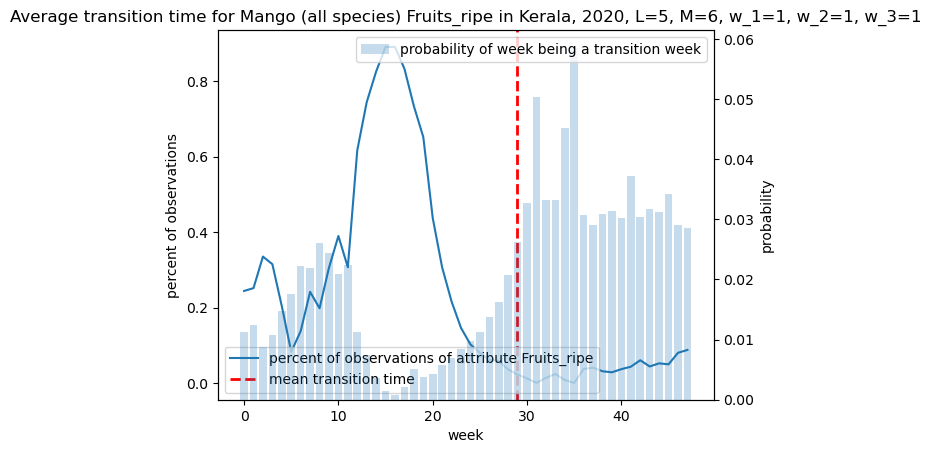

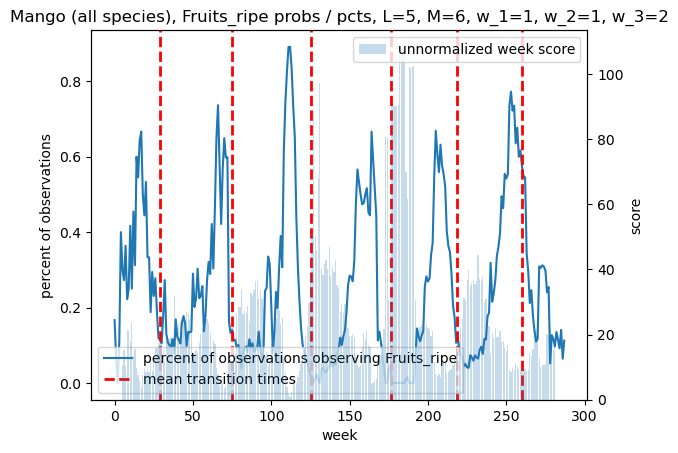

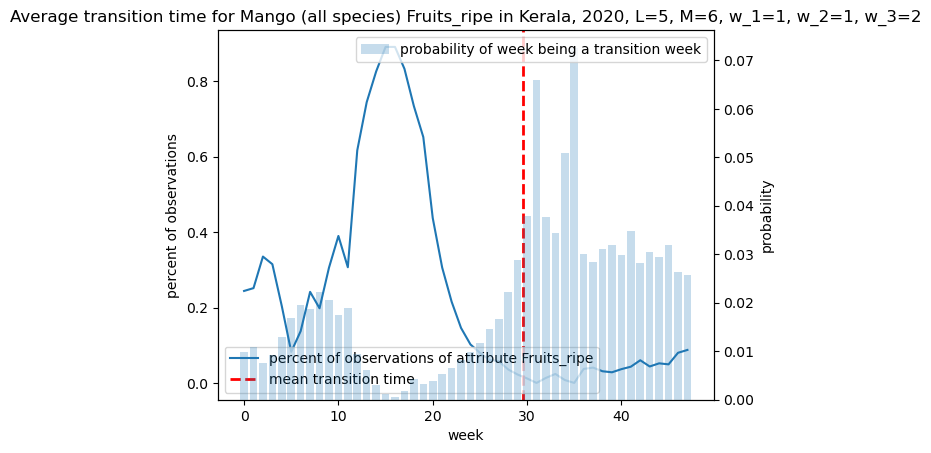

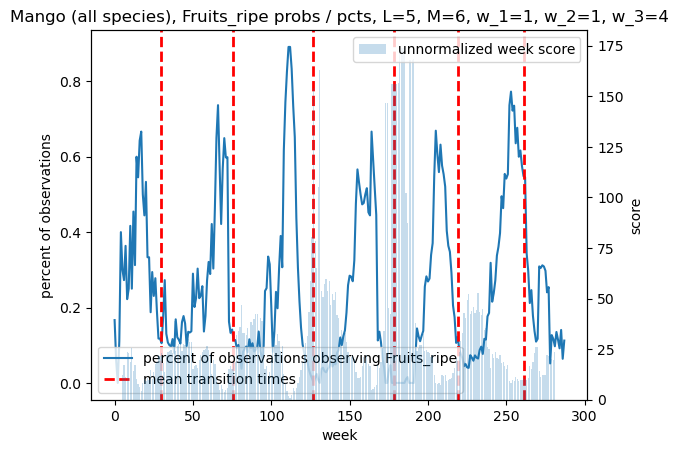

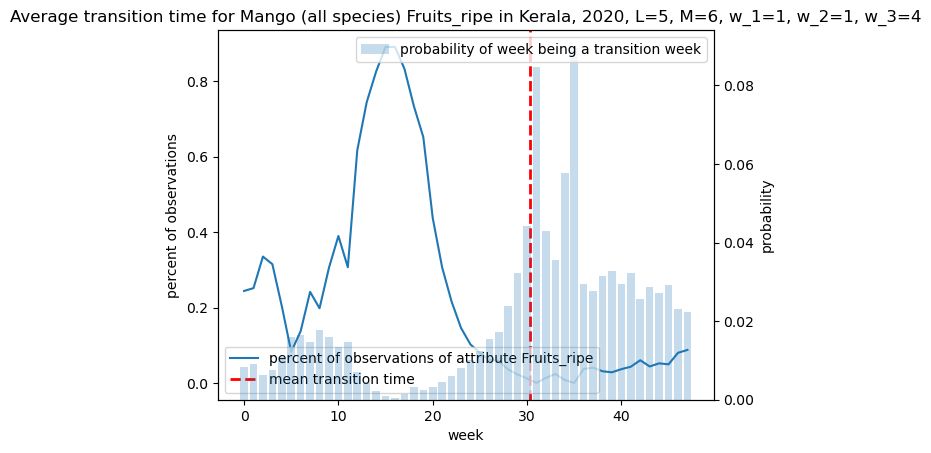

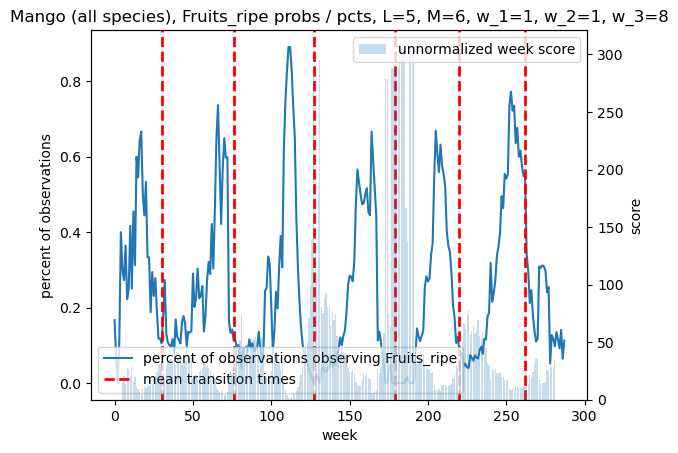

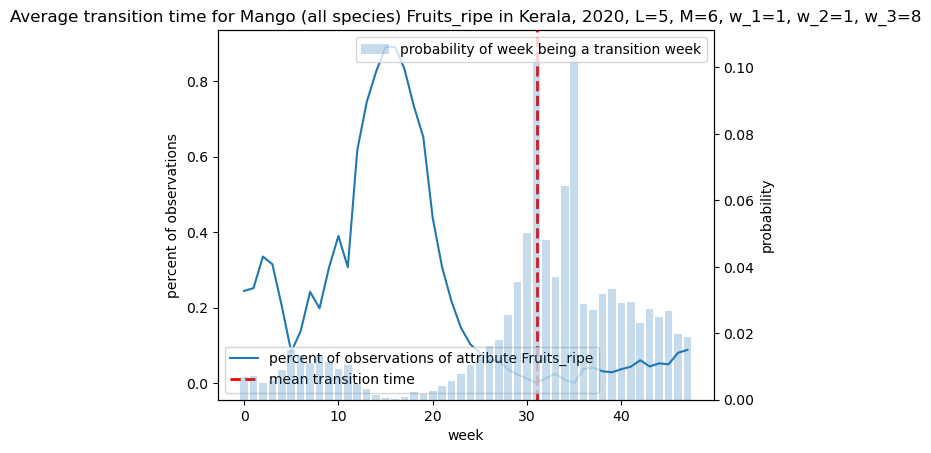

In [521]:
year = 2022
species_id = 1090
for w_1 in [1]:
    for w_2 in [1]:
        for w_3 in [1, 2, 4, 8]:
            for M in [6]:
                for L in [5]:
                    for attr in ['Fruits_ripe']:
                        # plot_stagnations(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)
                        # plot_spikes(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2)
                        plot_score_and_pcts(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=True)
                #plot_score_for_one_year(year, 1161, attr, L=5, M=M, w_1=w_1, w_2=w_2)

In [532]:
def get_scores(state_df, species_id, attr, L=5, M=3, w_1=1, w_2=1, w_3=1, size_term=False):
    pcts = []
    for year in range(2018, 2024):
        pcts += get_percent_of_positive_observations_for_each_week(state_df, year, species_id, attr)
    scores = []
    stagns = []
    spikes = []
    sizes = []
    for week in range(L, len(pcts)-M, 1): # todo - calculate score for weeks before week L
        #print(pcts[week-L:week+1])
        stagn = (1 / (0.1 + max(pcts[week-L:week+1]) - min(pcts[week-L:week+1])))**2
        spike = max(0, pcts[week + M] - pcts[week])
        size = 1 / (0.01 + pcts[week])
        
        spikes.append(spike)
        stagns.append(stagn)
        sizes.append(size)
    #print(scores)
    spikes = 100 * (np.array(spikes) - np.min(spikes)) / np.max(spikes)
    sizes = 100 * (np.array(sizes) - np.min(sizes)) / np.max(sizes)
    if size_term:
        scores = (w_1 * np.array(stagns) + w_2 * np.array(spikes) + w_3 * np.array(sizes)) / 3
        return list(scores), list(spikes), list(stagns), list(sizes)
    scores = (w_1 * np.array(stagns) + w_2 * np.array(spikes)) / 2
    return list(scores), list(spikes), list(stagns)

## Experiments with new spike term in score function
Spike term is now measuring increase in percent of observations M weeks after current week.


$$
    s(w) = w_1 \left|\max_{w - L \leq k \leq w} y(k) - \min_{w - L \leq k \leq w} y(k)\right|^{-1} + w_2 \max\left(y(w+M) - y(w), 0\right)
$$

We experiment with different values of the stagnation weight, $w_1$, and fix $w_2=1$. We fix $L=10$ and $M=15$

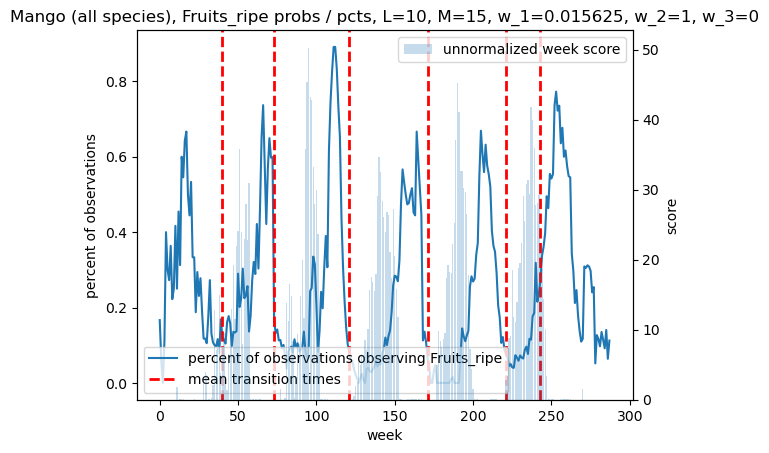

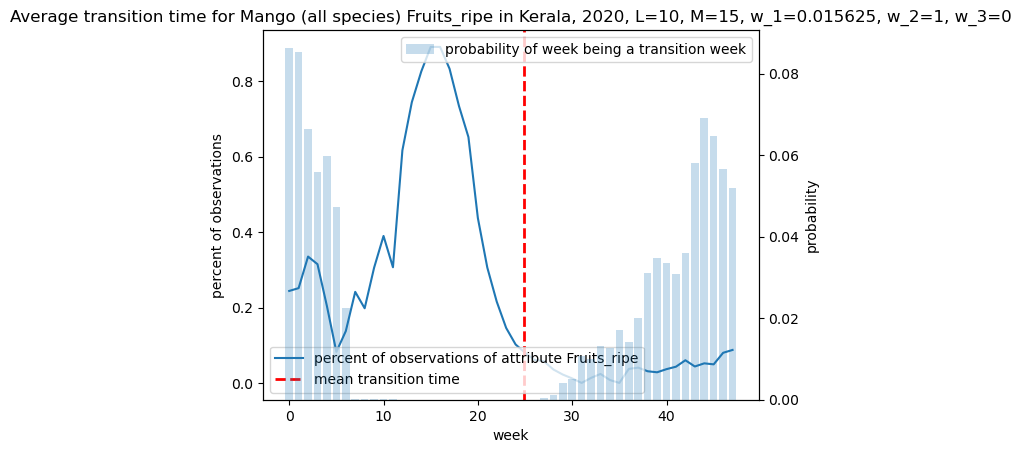

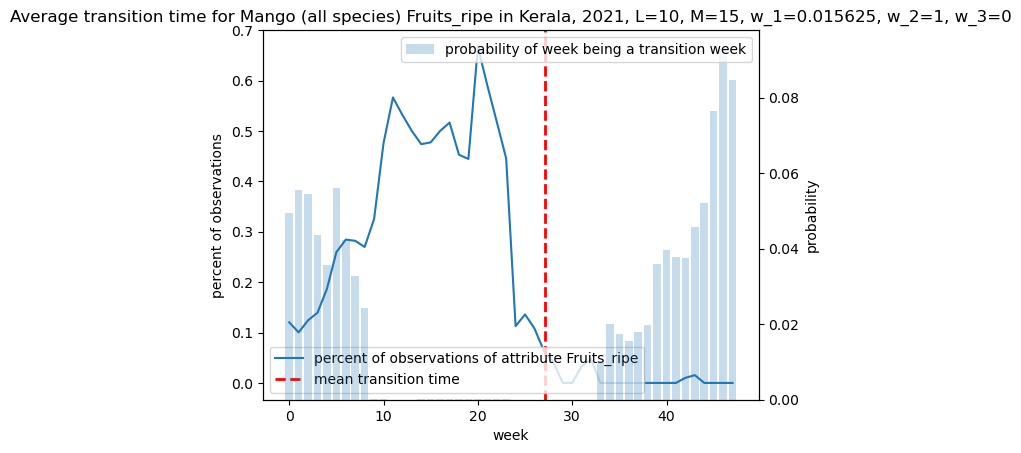

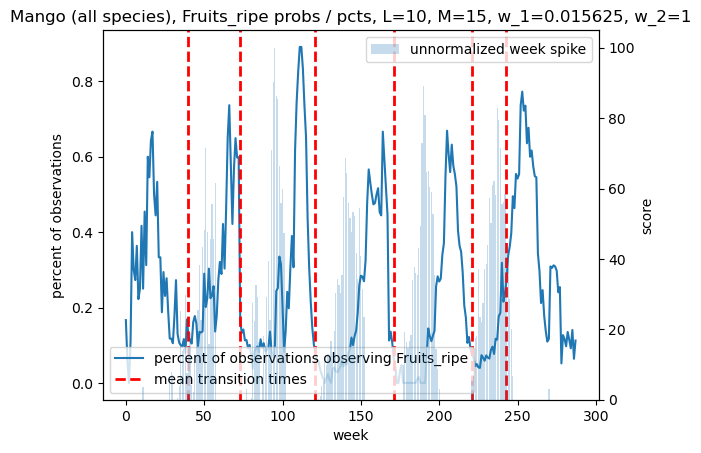

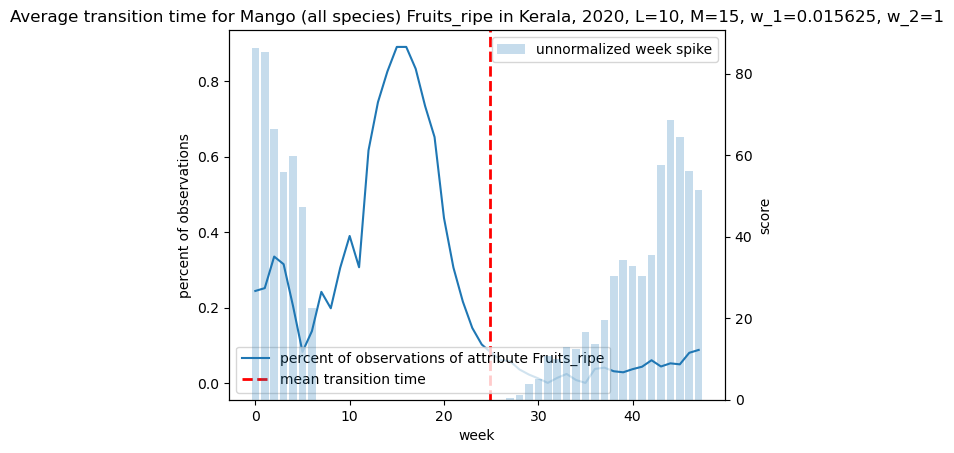

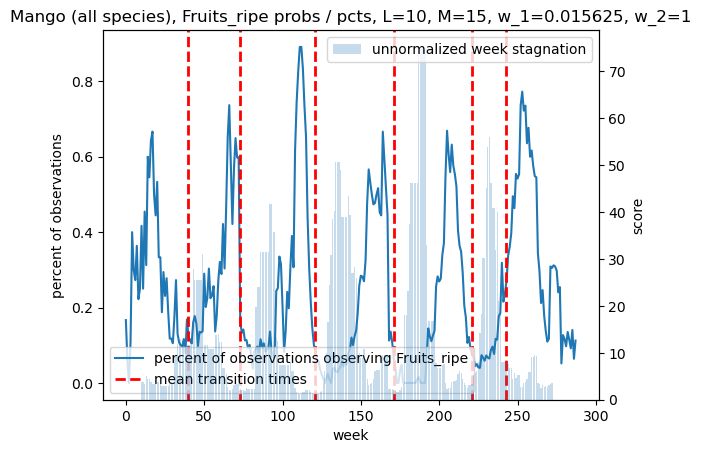

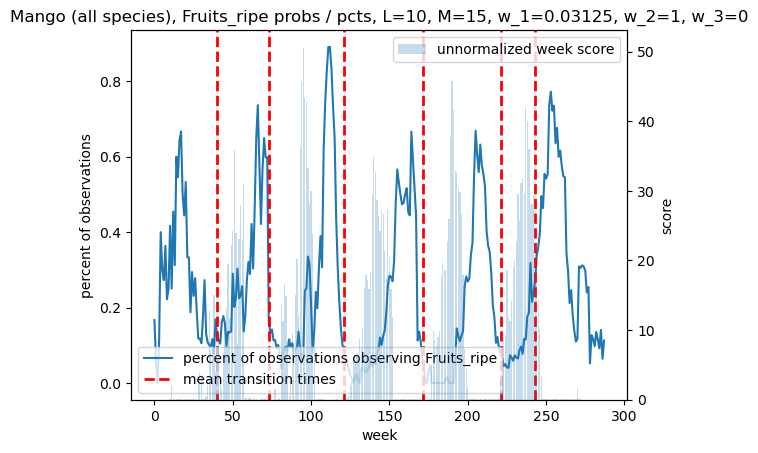

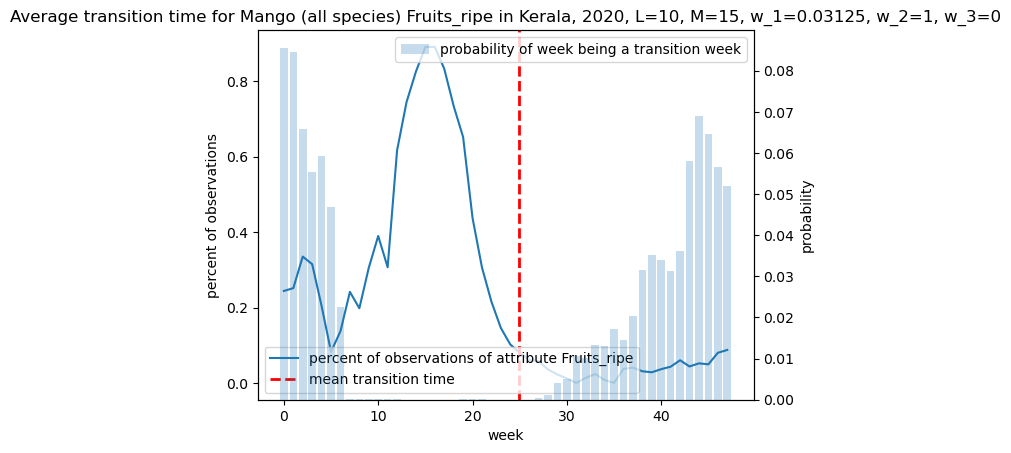

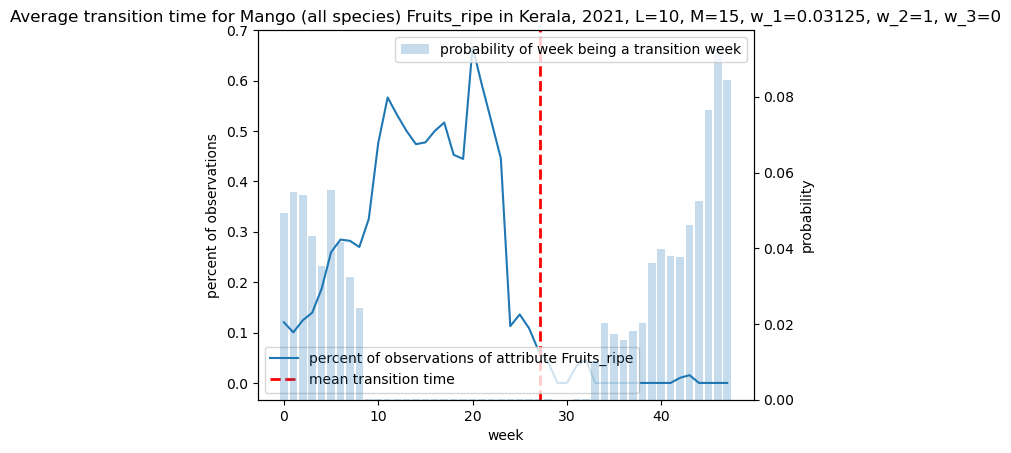

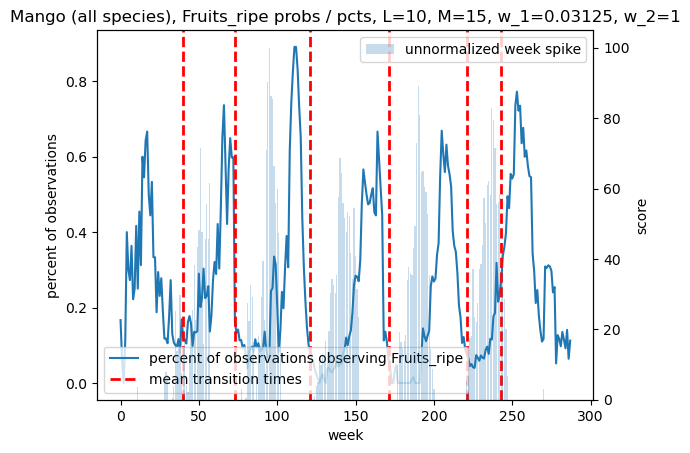

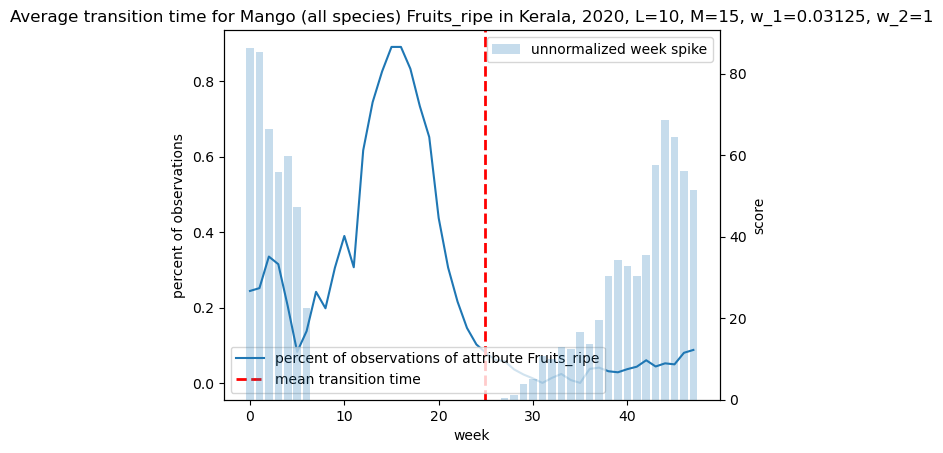

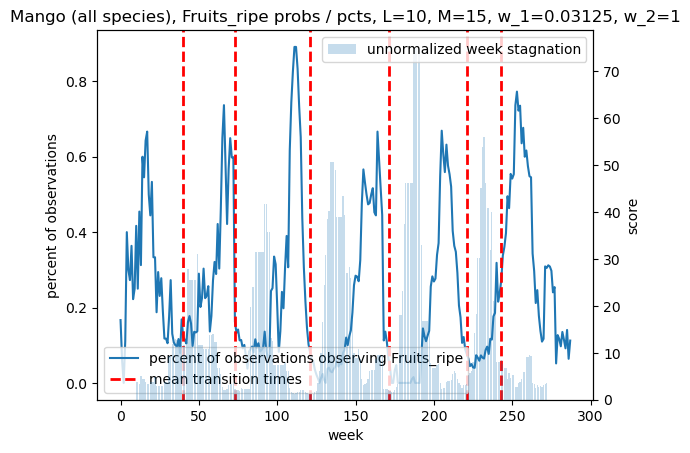

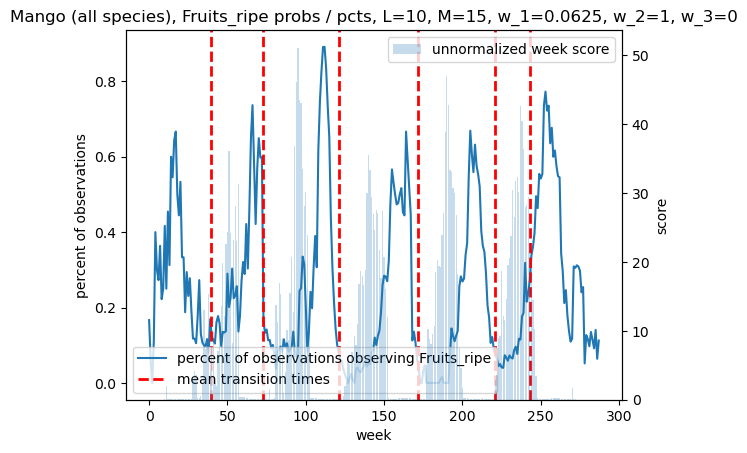

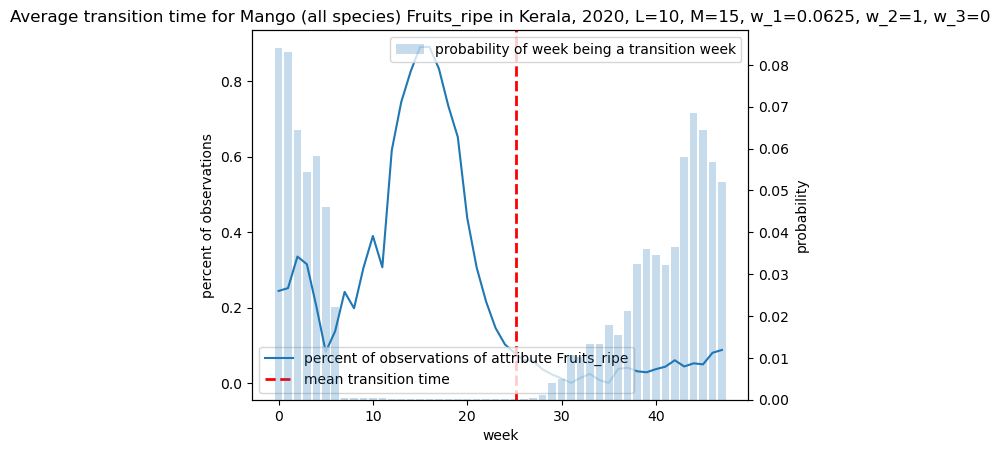

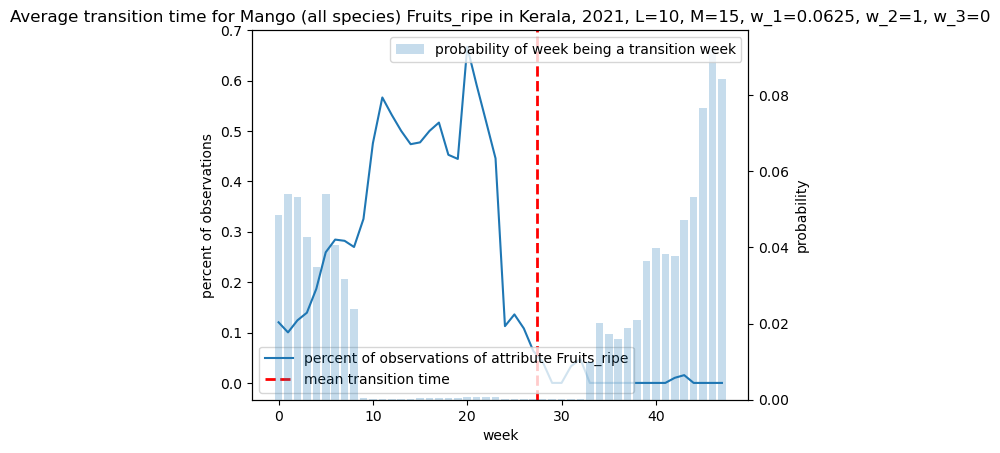

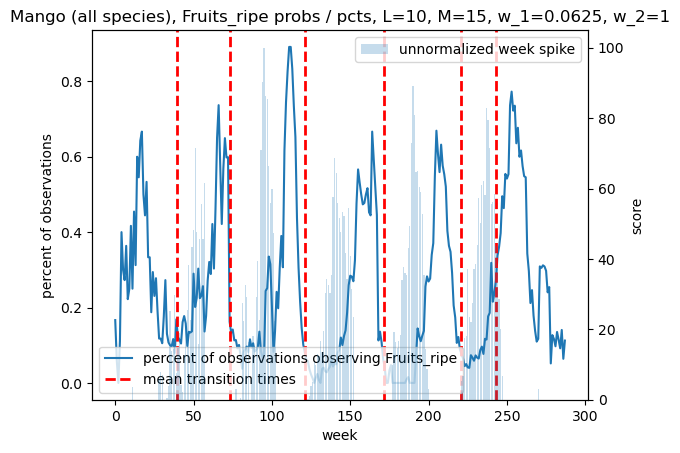

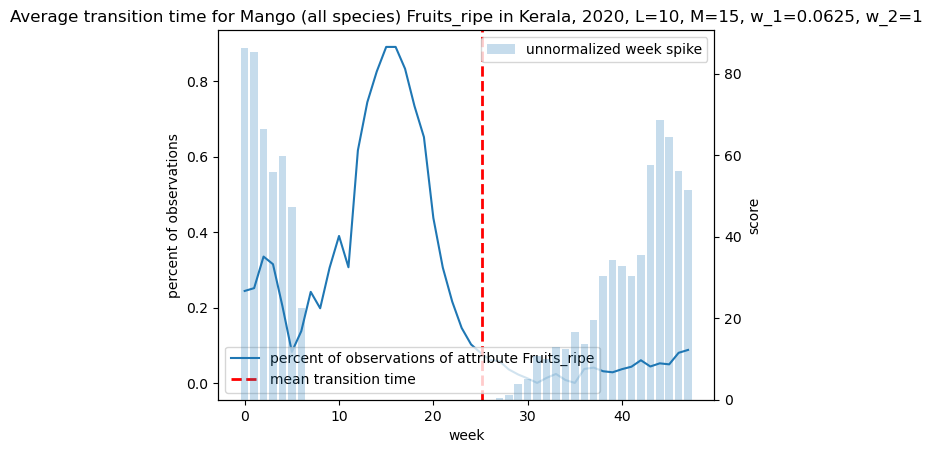

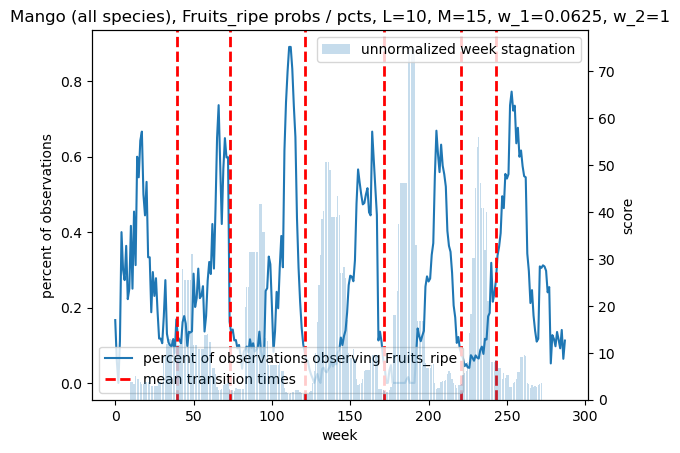

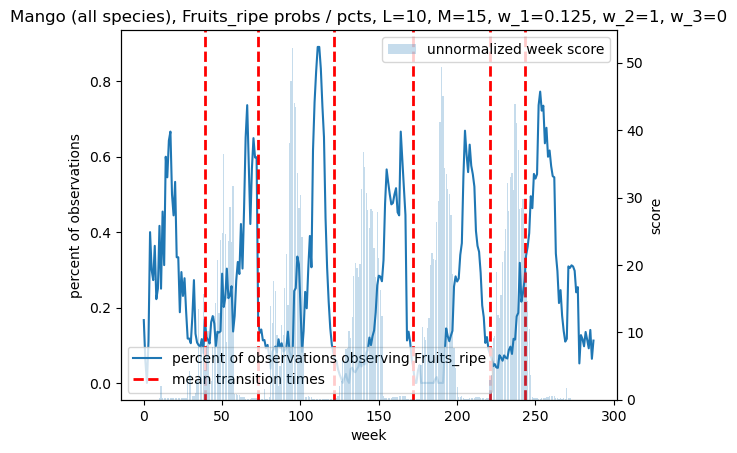

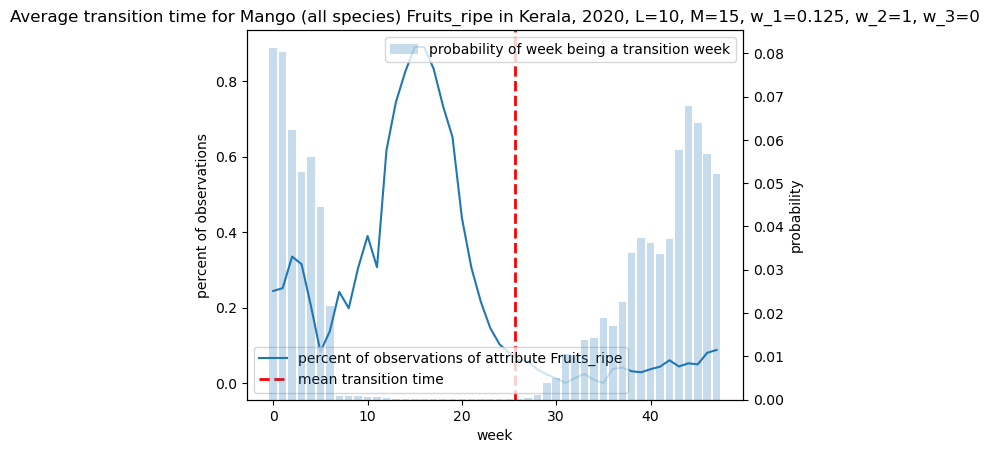

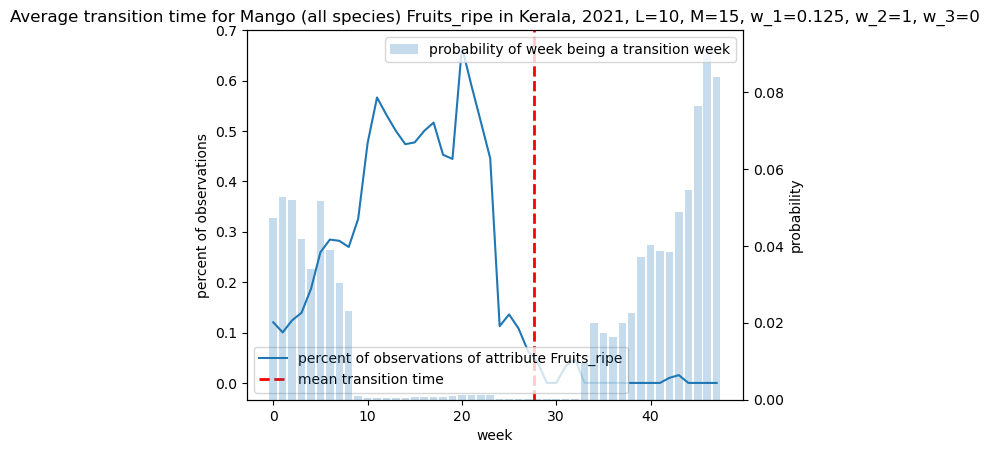

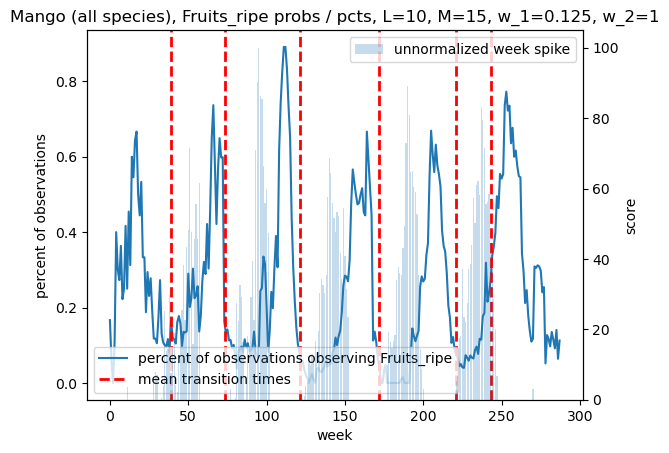

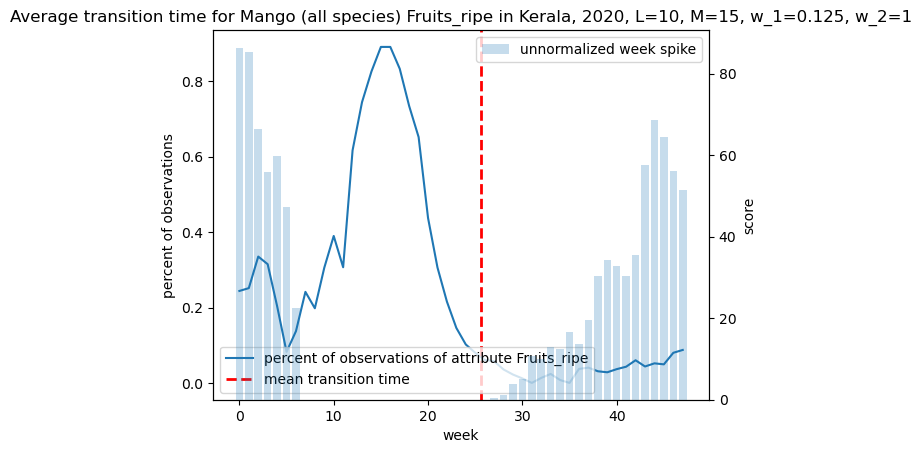

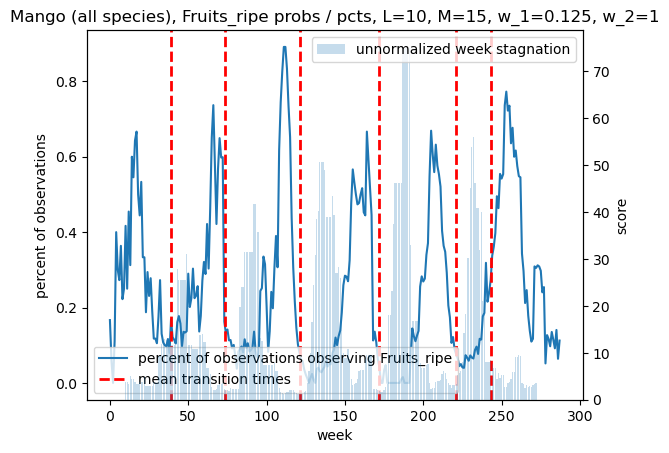

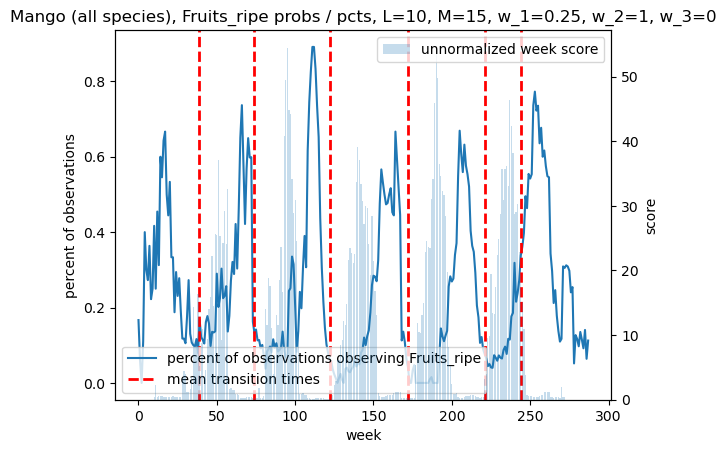

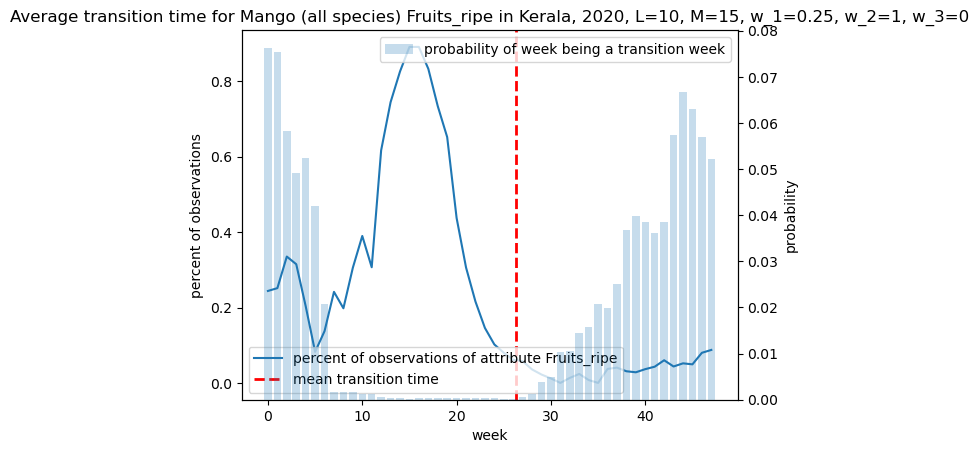

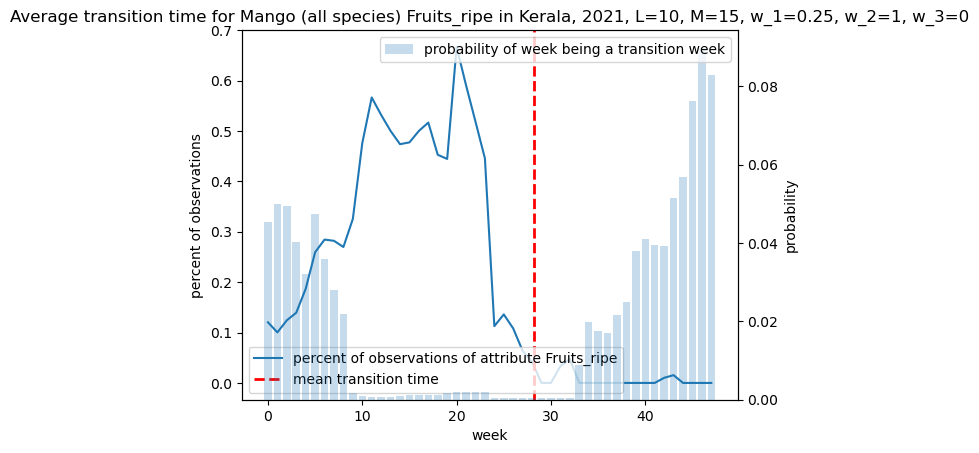

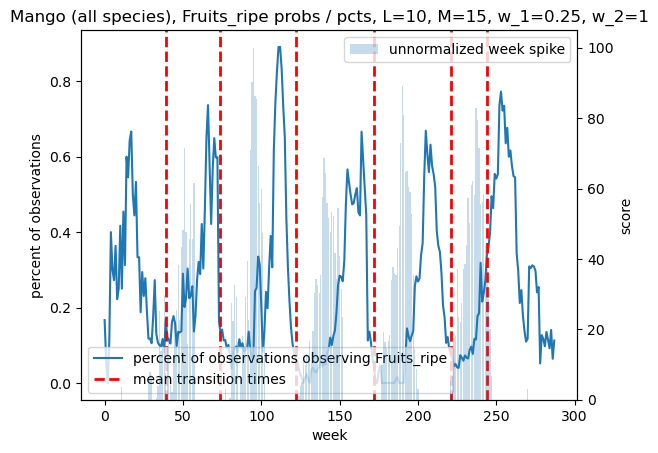

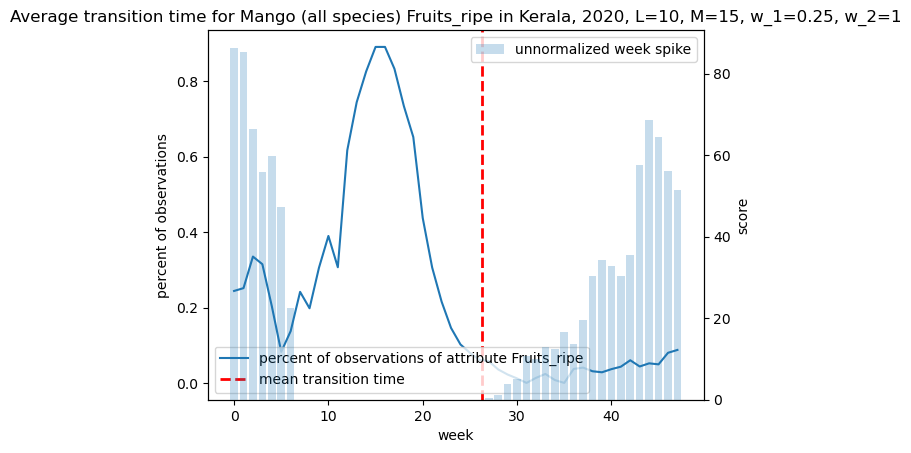

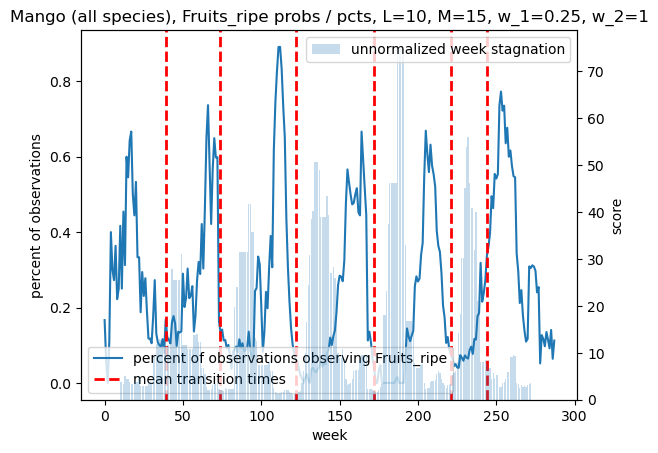

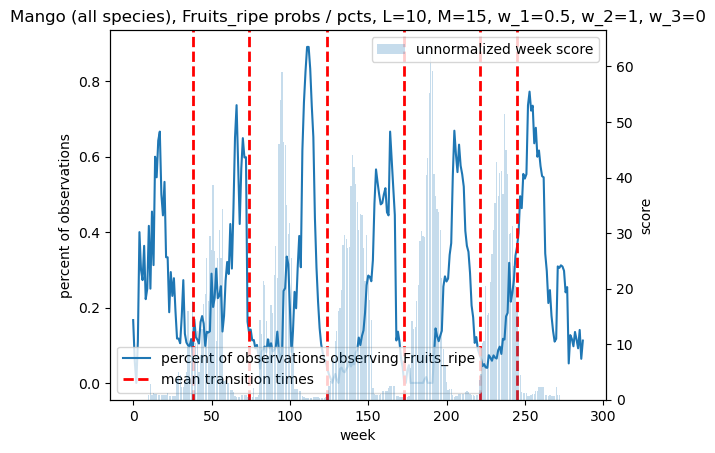

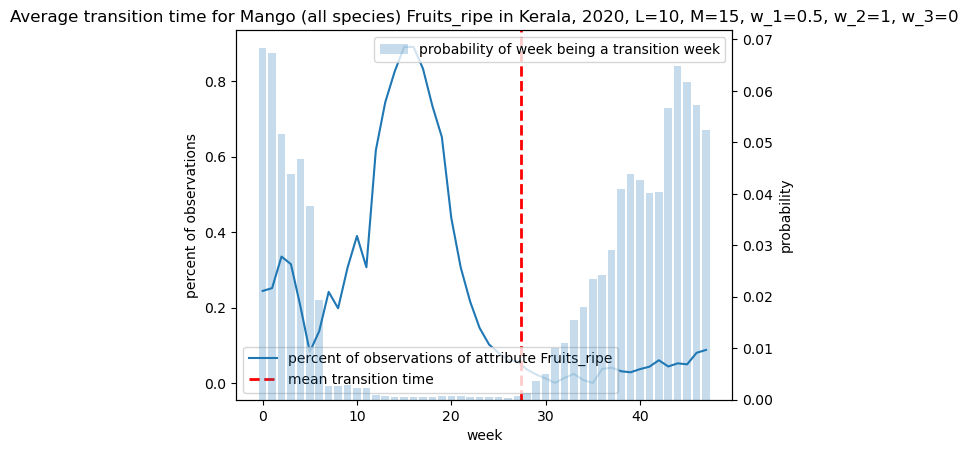

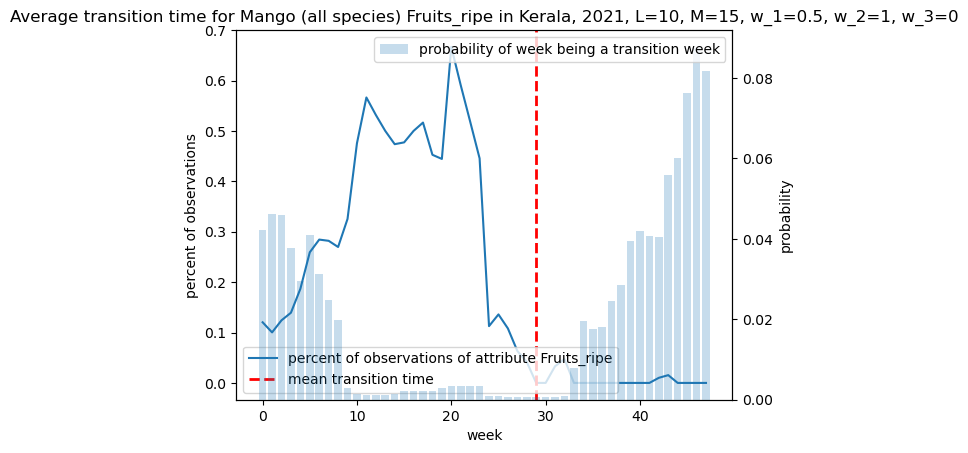

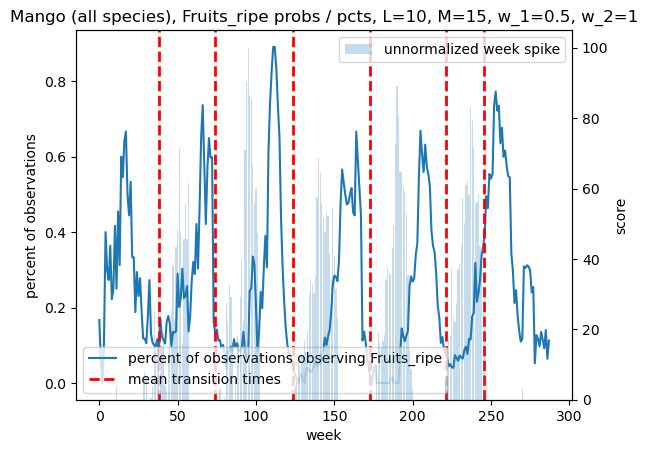

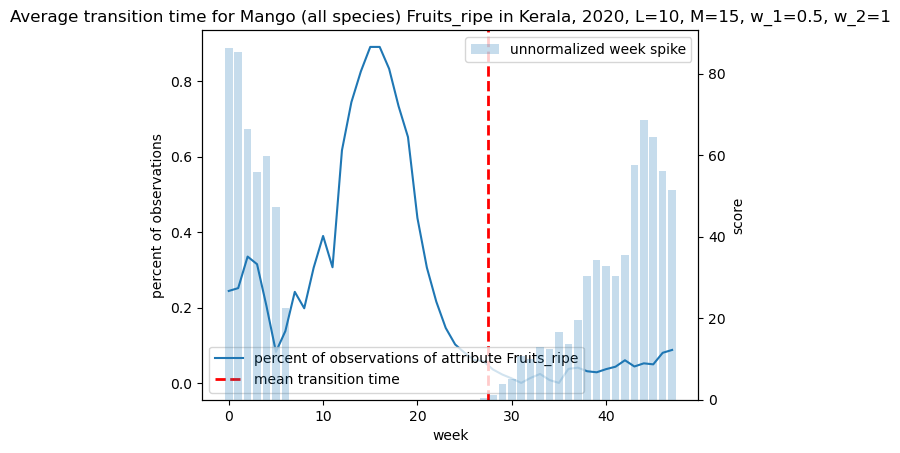

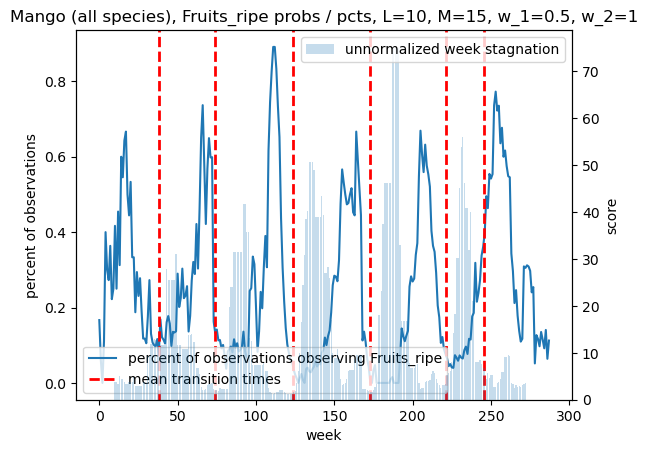

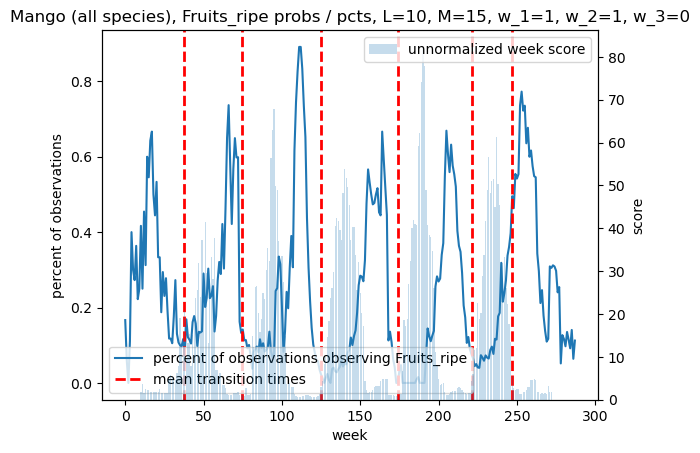

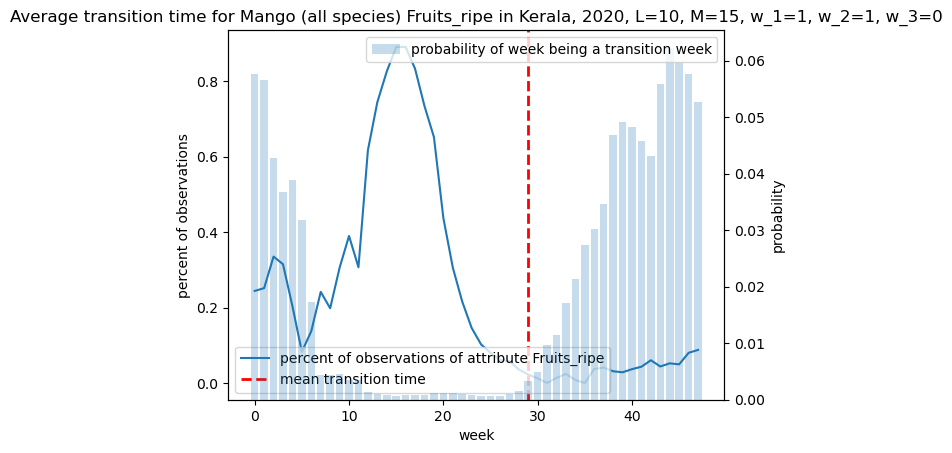

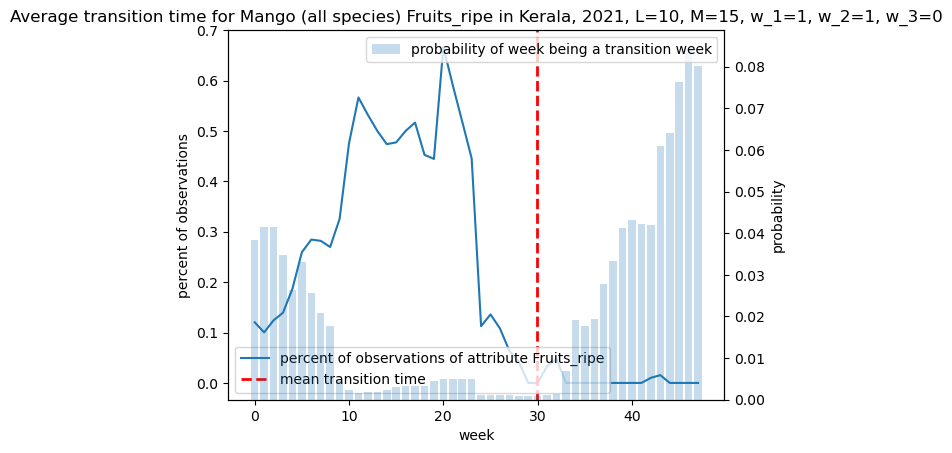

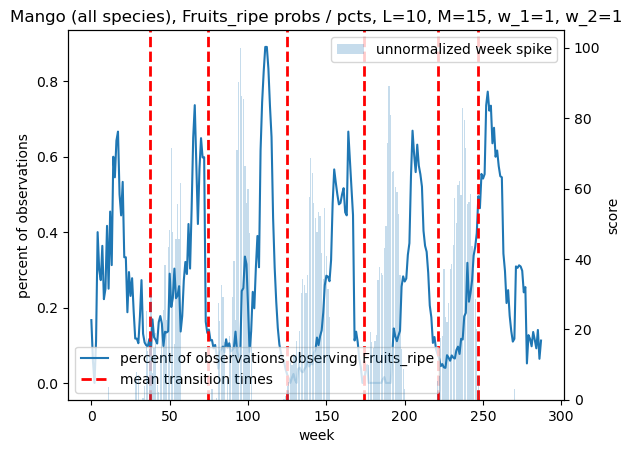

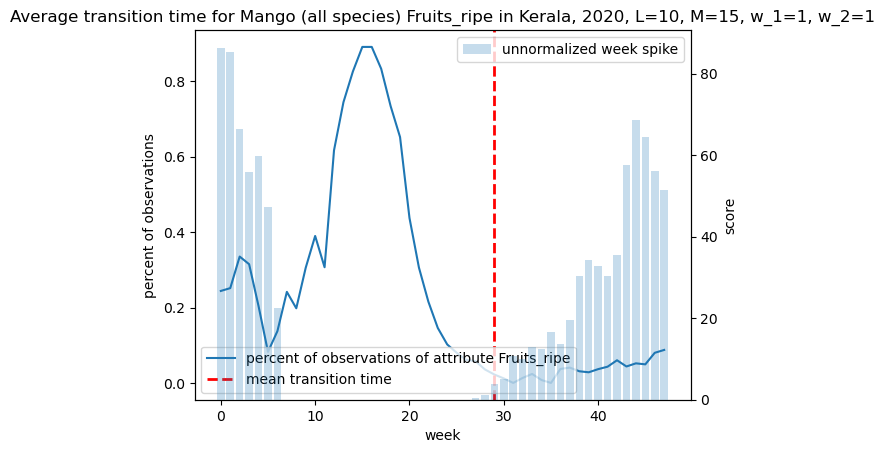

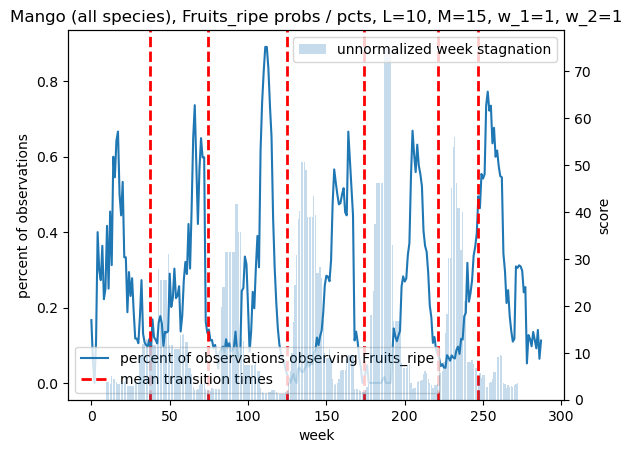

In [536]:
year = 2022
species_id = 1090
for w_1 in [0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1]:
    for w_2 in [1]:
        for w_3 in [0]:
            for M in [15]:
                for L in [10]:
                    for attr in ['Fruits_ripe']:
                        plot_score_and_pcts(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=False)
                        plot_spikes(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=False)
                        plot_stagnations(species_id, attr, L=L, M=M, w_1=w_1, w_2=w_2, w_3=w_3, size_term=False)

## Ideas
- Calculate means by centering distributions around weeks with high scores